# Part-1: ARMA model on catfish data
# Part-2: SARIMA model on catfish data


# Part-1: **ARMA Model** on catfish Data

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
register_matplotlib_converters()

In [106]:
import warnings
warnings.filterwarnings('ignore')

In [107]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# Catfish Sales Data

In [108]:
# Convert time stamp which is in string format to date-time object
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [109]:
# Read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)
#catfish_sales

In [110]:
# Infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))
#catfish_sales

## Slice Data to limited period to study further

In [111]:
# Slice data from Jan, 2000 to Jan, 2004
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

In [65]:
#lim_catfish_sales['Total'].values

## Plot the Data

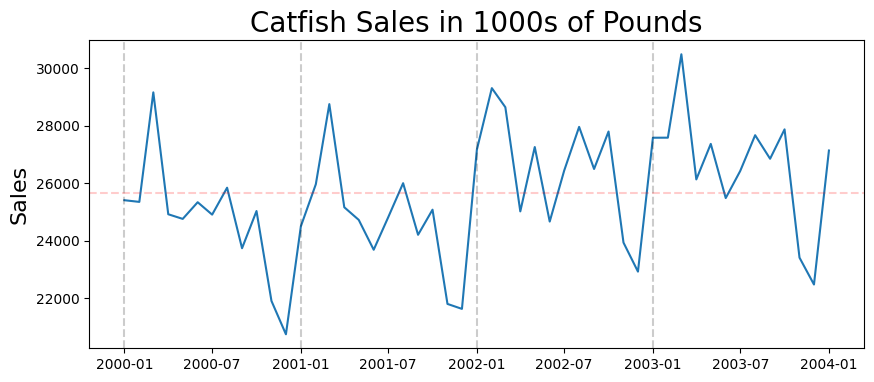

In [112]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales['Total'].values.mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

#### The plot show a strong repetitive seasonal pattern. Demand spikes towards the start of each year and then dips dows towards the end.
#### Data is roughly centered around 26000.

## Make stationary with the first difference

Now data centers around zero.

In [113]:
data = lim_catfish_sales.diff()[1:] # Remove the first value with is a NaN

## Plot again

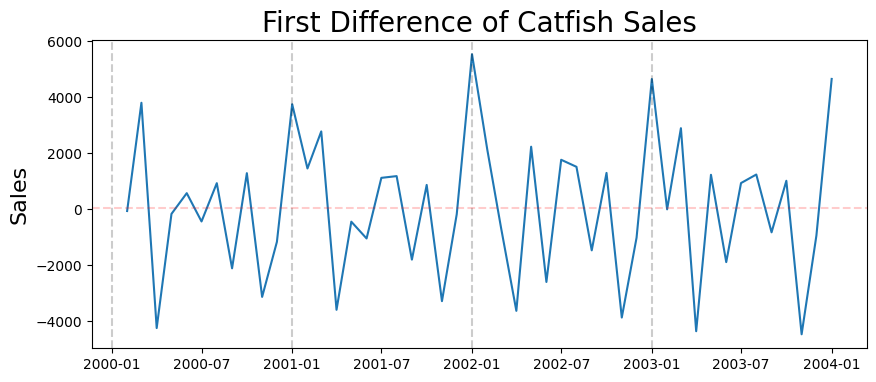

In [114]:
plt.figure(figsize=(10,4))
plt.plot(data)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(data['Total'].values.mean(), color='r', alpha=0.2, linestyle='--')

### Data is zero centered and the variance is roughly the same.

In [115]:
#check stationarity
perform_adf_test(data)

ADF Statistic: -8.052801
p-value: 0.000000


# ACF

<BarContainer object of 15 artists>

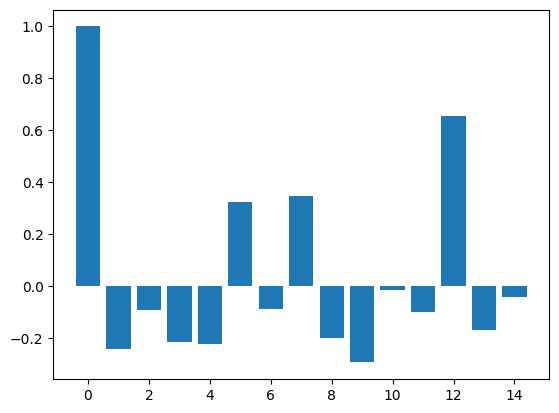

In [116]:
num_lags = 15
acf_vals = acf(data)
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a MA(1) process

# PACF

<BarContainer object of 15 artists>

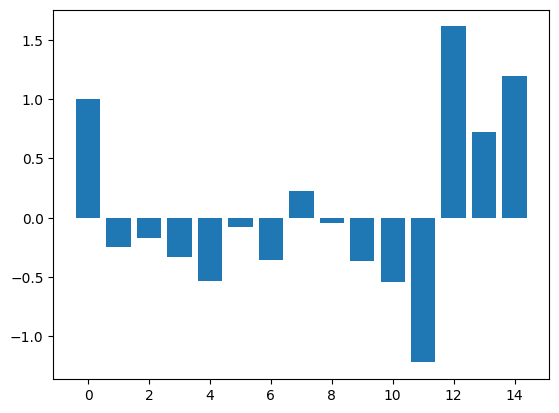

In [117]:
pacf_vals = pacf(data)
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a AR(4) process

# Get training and testing sets

In [118]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = data[:train_end]
test_data = data[train_end + timedelta(days=1):test_end]

# Fit the ARMA Model

In [119]:
# define model
model_arma = ARIMA(train_data, order=(4,0,1))
#model_arma= ARIMA(train_data, order=(4,1,1))


In [120]:
#fit the model
start = time()
model_fit = model_arma.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.1856083869934082


In [121]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -376.598
Date:                Sun, 25 Jun 2023   AIC                            767.195
Time:                        10:35:12   BIC                            779.359
Sample:                    02-01-2000   HQIC                           771.654
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1795    179.935      0.134      0.893    -328.487     376.846
ar.L1         -0.8659      0.222     -3.896      0.000      -1.302      -0.430
ar.L2         -0.4234      0.246     -1.724      0.0

### So the ARMA(4,1) model is:
### Predicted Model

## **y_hat(t) = 24 - 0.86*y(t-1) - 0.42*y(t-2) - 0.55*y(t-3) - 0.61*y(t-4) + 0.51*error(t-1)**

In [122]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [128]:
# #get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['Total'].values - predictions

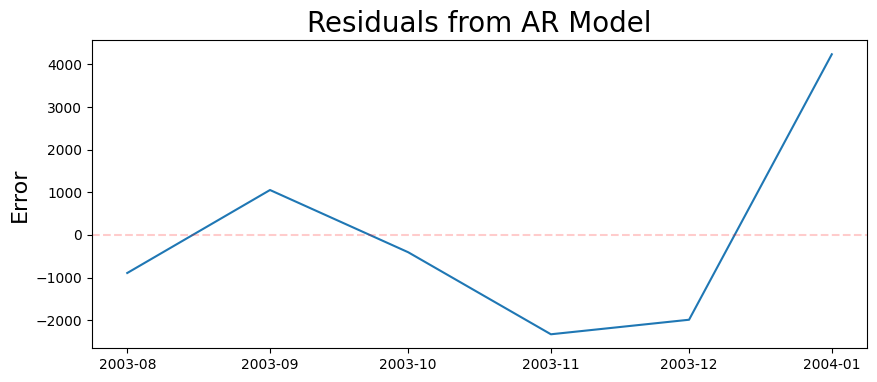

In [129]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

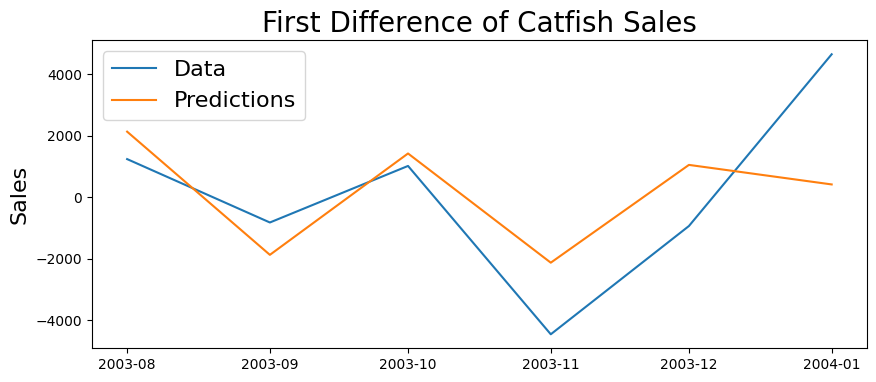

In [130]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#-------------------------------------------------------------------------------------------
# No Luck with ARIMA
# This part may be omitted from discussion
#-------------------------------------------------------------------------------------------

Model Fitting Time: 0.08897614479064941
                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -378.399
Date:                Sun, 25 Jun 2023   AIC                            762.798
Time:                        10:40:33   BIC                            767.939
Sample:                    02-01-2000   HQIC                           764.670
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2585      0.170     -1.524      0.127      -0.591       0.074
ma.L1         -1.0000      0.267     -3.746      0.000      -1.523      -0.477
sigma2      

Text(0, 0.5, 'Sales')

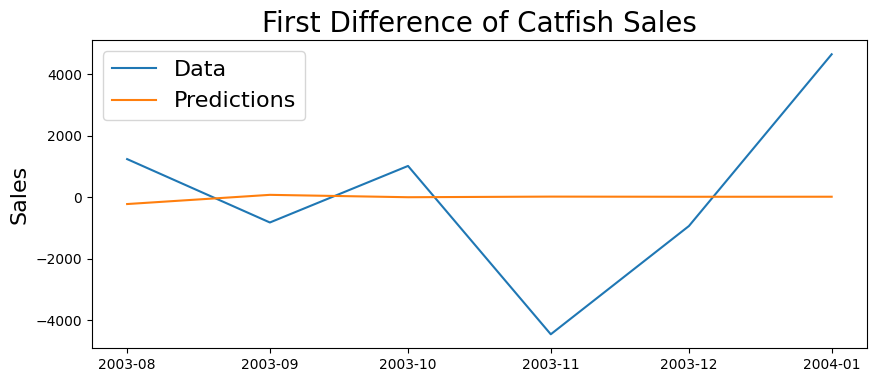

In [134]:
# define model
model_arma = ARIMA(train_data, order=(1,1,1))

#fit the model
start = time()
model_fit = model_arma.fit()
end = time()
print('Model Fitting Time:', end - start)

#summary of the model
print(model_fit.summary())

#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# #get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['Total'].values - predictions

plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)


In [136]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Total'].values)),4))
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals**2)))


Mean Absolute Percent Error: 1.0486
Root Mean Squared Error: 2783.9747498970805


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Continue with SARIMA**

## Get a different chunk of data

In [137]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

## Different start and aend data to show some upward trend in data

In [138]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

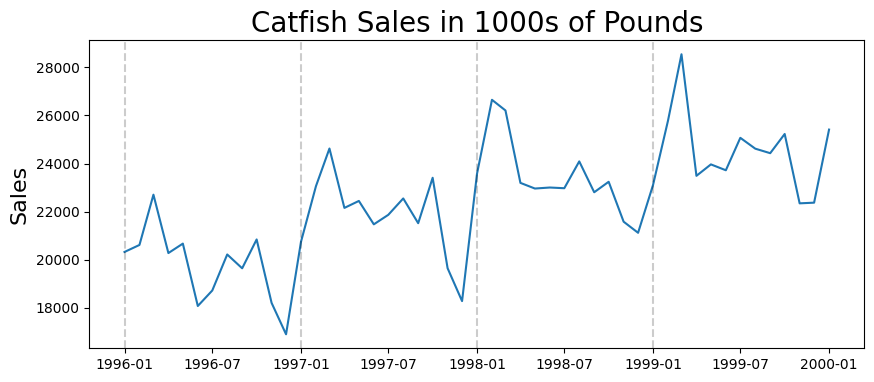

In [139]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Remove Trend

In [140]:
first_diff = lim_catfish_sales.diff()[1:]

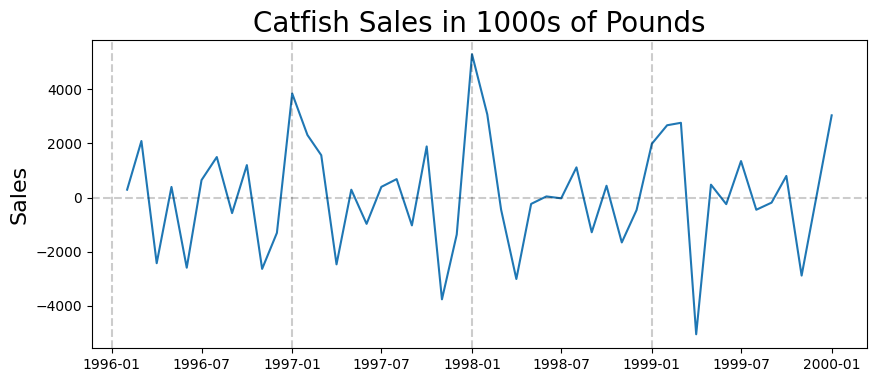

In [141]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

<BarContainer object of 15 artists>

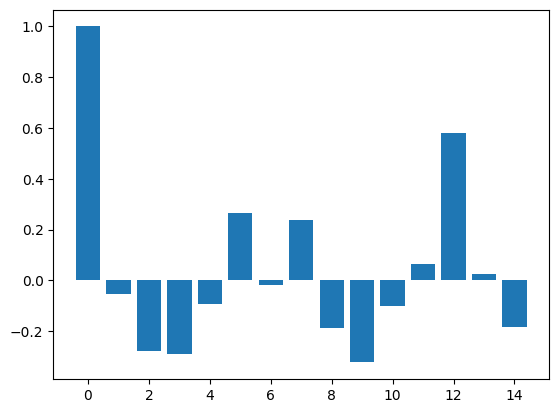

In [142]:
acf_vals = acf(first_diff)
num_lags = 15
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process (with a lag/period of 12 months as the order for the seasonal component as we see a spike at 12 in the above plot, suggesting that there is a seasonal component.)

# PACF

<BarContainer object of 15 artists>

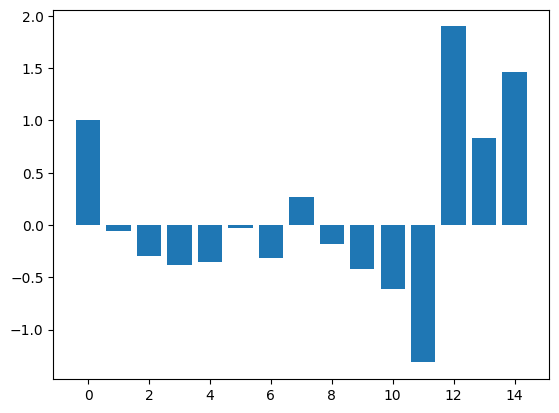

In [143]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [144]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Fit SARIMA Model

In [145]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [146]:
my_order = (0,1,0) # non-seasonal part - AR, I, MA
# We observe a pure seasonal behaviour in AR and MA but we have integrated 1 as the first difference makes it stationary
my_seasonal_order = (1, 0, 1, 12) # Seasonal AR, I, MA and Frequency of data (how many data points we have per year, since it is a monthly data, we have 12 data-points every year)

# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [147]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.297863245010376


In [148]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Sun, 25 Jun 2023   AIC                            737.269
Time:                                      11:04:34   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [149]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

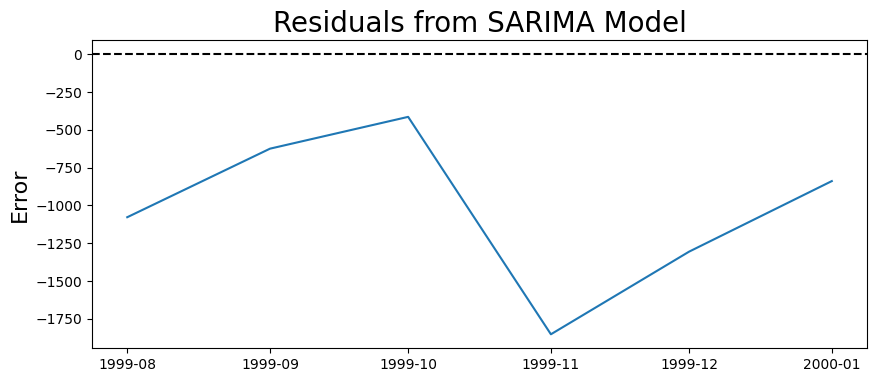

In [150]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

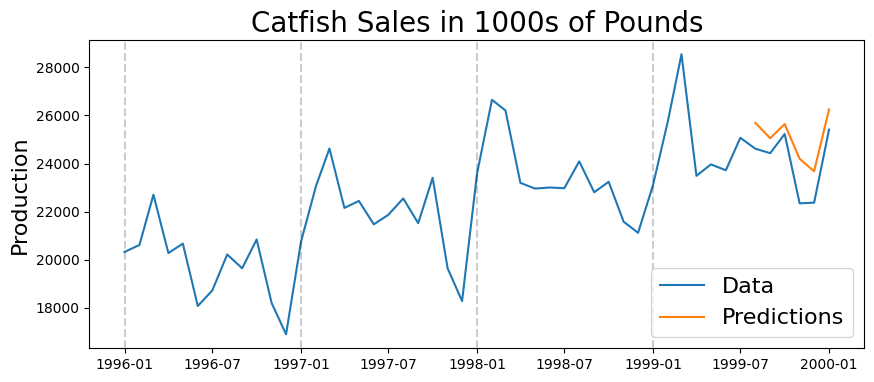

In [151]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [152]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [153]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.3047197056494


# Improvement with Using the Rolling Forecast Origin

In [154]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [155]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

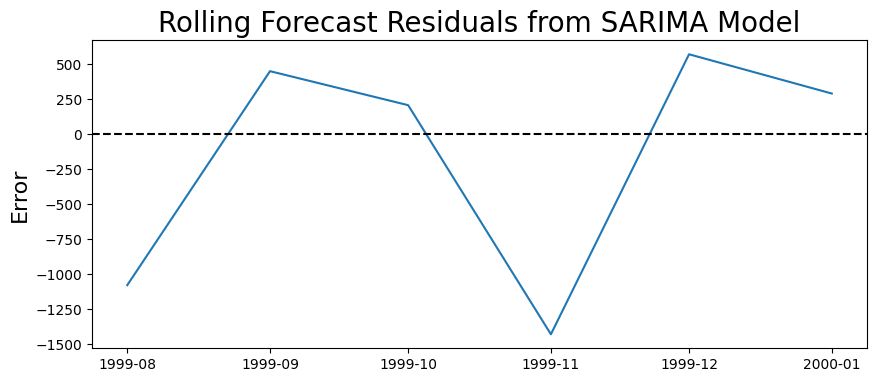

In [156]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

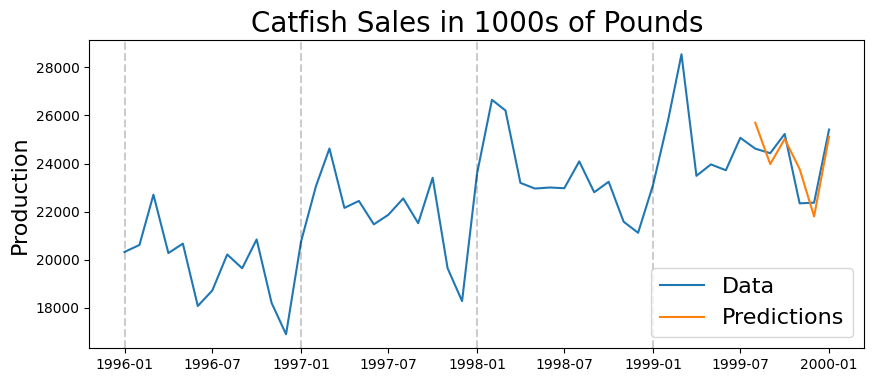

In [157]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [158]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0286


In [159]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 802.3547518758006
